# Read Data

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ruchi798/bookcrossing-dataset

 95% 72.0M/76.1M [00:02<00:00, 51.2MB/s]
100% 76.1M/76.1M [00:02<00:00, 37.3MB/s]


In [ ]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/bookcrossing-dataset.zip

Archive:  /content/bookcrossing-dataset.zip
  inflating: Book reviews/Book reviews/BX-Book-Ratings.csv  
  inflating: Book reviews/Book reviews/BX-Users.csv  
  inflating: Book reviews/Book reviews/BX_Books.csv  
  inflating: Books Data with Category Language and Summary/Preprocessed_data.csv  


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


# Data Understanding

In [101]:
path = "/content/Book reviews/Book reviews/"
df_user = pd.read_csv(path+'BX-Users.csv', sep=";", error_bad_lines=False,encoding='latin-1')

df_books = pd.read_csv(path+'BX_Books.csv', sep=";", error_bad_lines=False,encoding='latin-1')

df_rating = pd.read_csv(path+'BX-Book-Ratings.csv', sep=";", error_bad_lines=False,encoding='latin-1')

<ipython-input-101-dfd0fca07254>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_user = pd.read_csv(path+'BX-Users.csv', sep=";", error_bad_lines=False,encoding='latin-1')
<ipython-input-101-dfd0fca07254>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_books = pd.read_csv(path+'BX_Books.csv', sep=";", error_bad_lines=False,encoding='latin-1')
<ipython-input-101-dfd0fca07254>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_rating = pd.read_csv(path+'BX-Book-Ratings.csv', sep=";", error_bad_lines=False,encoding='latin-1')


# Exploratory Data Analysis (EDA)

In [102]:
df_user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [103]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [104]:
df_rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [105]:
merged_book_df = df_rating.merge(df_books, on='ISBN')
merged_book_df.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [106]:
df_books = df_books.drop(['Year-Of-Publication', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)
rating_book = df_books.merge(df_rating, on='ISBN')
rating_book.head()

,ISBN,Book-Title,Book-Author,Publisher,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,41385,0


### Tambahkan jumlah peringkat yang ditetapkan. Hapus dari pengguna yang memberi peringkat beberapa kali


In [107]:
number_rating = rating_book.groupby('ISBN')['Book-Rating'].count().reset_index()
number_rating.rename(columns={'Book-Rating': 'Number of Book-Rating'}, inplace=True)
rating_book = rating_book.merge(number_rating, on='ISBN')
rating_book

,ISBN,Book-Title,Book-Author,Publisher,User-ID,Book-Rating,Number of Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press,2,0,1
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,8,5,14
2,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11400,0,14
3,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,11676,8,14
4,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,41385,0,14
...,...,...,...,...,...,...,...
1031170,0440400988,There's a Bat in Bunk Five,Paula Danziger,Random House Childrens Pub (Mm),276463,7,1
1031171,0525447644,From One to One Hundred,Teri Sloat,Dutton Books,276579,4,1
1031172,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,HarperSanFrancisco,276680,0,1
1031173,0192126040,Republic (World's Classics),Plato,Oxford University Press,276680,0,1


###  memfilter rating_book diatas 30

In [108]:
rating_book = rating_book[rating_book['Number of Book-Rating'] > 30]

<Axes: xlabel='Number of Book-Rating', ylabel='count'>

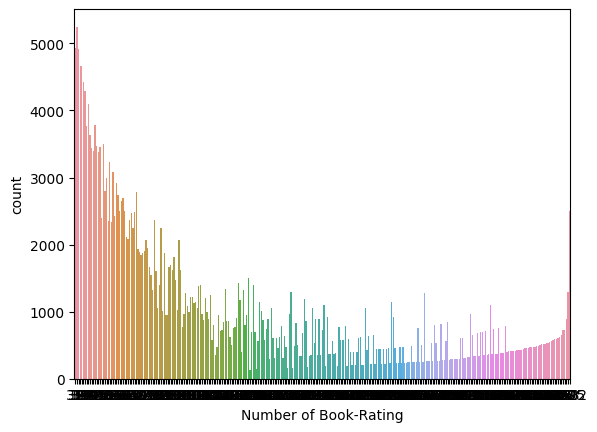

In [109]:
sns.countplot(x=rating_book['Number of Book-Rating'])

### menghapus duplikat data


In [110]:
rating_book.drop_duplicates(['User-ID', 'Book-Title'], inplace=True)
rating_book.shape

<ipython-input-110-487ae7e8e22e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_book.drop_duplicates(['User-ID', 'Book-Title'], inplace=True)


(307642, 7)

# Encoding Data

In [111]:
rating_book_df = rating_book[['ISBN','Book-Rating', 'User-ID']]


user_ids = rating_book_df['User-ID'].unique().tolist()
user_encoded = {x: i for i, x in enumerate(user_ids)}
user_to_user_encoded = {i: x for i, x in enumerate(user_ids)}

book_ids = rating_book_df['ISBN'].unique().tolist()
book_encoded = {x: i for i, x in enumerate(book_ids)}
book_to_book_encoded = {i: x for i, x in enumerate(book_ids)}

print('Encoded user-id :', dict(list(user_encoded.items())[0: 10]))
print('Encoded book-id (isbn) :', dict(list(book_encoded.items())[0: 10]))

Encoded user-id : {8: 0, 11676: 1, 29526: 2, 36836: 3, 46398: 4, 49300: 5, 49635: 6, 67958: 7, 113270: 8, 113519: 9}
Encoded book-id (isbn) : {'0399135782': 0, '0440234743': 1, '0452264464': 2, '1841721522': 3, '0971880107': 4, '0345402871': 5, '0345417623': 6, '0446310786': 7, '0449005615': 8, '0060168013': 9}


In [112]:
rating_book_df['user_id'] = rating_book_df['User-ID'].map(user_encoded)
rating_book_df['isbn'] = rating_book_df['ISBN'].map(book_encoded)
rating_book_df.head()

<ipython-input-112-ec291327135f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_book_df['user_id'] = rating_book_df['User-ID'].map(user_encoded)
<ipython-input-112-ec291327135f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_book_df['isbn'] = rating_book_df['ISBN'].map(book_encoded)


,ISBN,Book-Rating,User-ID,user_id,isbn
30,0399135782,0,8,0,0
31,0399135782,9,11676,1,0
32,0399135782,9,29526,2,0
33,0399135782,0,36836,3,0
34,0399135782,9,46398,4,0


#### Mengubah data int ke float

In [131]:
rating_book_df['Book-Rating'] = rating_book_df['Book-Rating'].values.astype(np.float32)
rating_min = min(rating_book_df['Book-Rating'])
rating_max = max(rating_book_df['Book-Rating'])

In [132]:
rating_book_df['rating'] = rating_book_df['Book-Rating'].apply(lambda x: (x - rating_min) / (rating_max - rating_min)).values
rating_book_df = rating_book_df[['ISBN', 'User-ID', 'Book-Rating', 'user_id', 'isbn', 'rating']]
rating_book_df.head()


,ISBN,User-ID,Book-Rating,user_id,isbn,rating
30,0399135782,8,0.0,0.0,0.0,0.0
31,0399135782,11676,9.0,1.0,0.0,0.9
32,0399135782,29526,9.0,2.0,0.0,0.9
33,0399135782,36836,0.0,3.0,0.0,0.0
34,0399135782,46398,9.0,4.0,0.0,0.9


# Pembagian Data Uji dan Latih

In [135]:
from surprise import accuracy,SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


reader_svd = Reader(rating_scale=(0,1))
data_svd = Dataset.load_from_df(rating_book_df[['user_id', 'isbn', 'rating']], reader_svd)
trainset_svd, testset_svd = train_test_split(data_svd, test_size=0.2)


In [137]:
test_user_id = 276729
read_books = df_rating[df_rating['User-ID'] == test_user_id]
unread_books =  df_rating[~df_rating['ISBN'].isin(read_books.ISBN.values)]['ISBN']

In [138]:
svd = SVD()

svd.fit(trainset_svd)

In [140]:
df_svd_predict = unread_books.to_frame(name='ISBN')
df_svd_predict = df_svd_predict.merge(df_books[['ISBN','Book-Title','Book-Author']], left_on='ISBN', right_on='ISBN', how='left')
df_svd_predict['prediction_rate'] = unread_books.apply(lambda x: svd.predict(test_user_id, x).est)

n_top = 8
df_svd_predict.sort_values(by='prediction_rate',ascending=False).head(n_top)

,ISBN,Book-Title,Book-Author,prediction_rate
0,034545104X,Flesh Tones: A Novel,M. J. Rose,0.30515
766517,0671665871,GOING HOME,Danielle Steel,0.30515
766523,0671690582,WHISPER OF DEATH : WHISPER OF DEATH,Christopher Pike,0.30515
766522,0671690094,ANNE FRANK: DIARY OF A YOUNG GIRL,Anne Frank,0.30515
766521,067167630X,BOOMER,Charles Taylor,0.30515
766520,067167465X,BEST OF ENEMIES (NANCY DREW HARDY BOY SUPERMYS...,Carolyn Keene,0.30515
766519,0671673513,The SILENCE OF THE LAMBS,Thomas Harris,0.30515
766518,0671670662,WEB OF DREAMS (Casteel Saga (Paperback)),V.C. Andrews,0.30515


# Modeling

# Evaluation


In [ ]:
! pip install surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import SVD


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811630 sha256=1c4276e4f949a423f45e72a52db30eef66842f0f10b65ac59661850b93241300
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [115]:
reader = Reader(rating_scale=(1, 3))
data = Dataset.load_from_df (rating_book_df[['user_id','isbn','rating']],reader)
model = SVD()
results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3)

print("Mean RMSE:", results['test_rmse'].mean())
print("Mean MAE:", results['test_mae'].mean())

Mean RMSE: 0.7989398195004128
Mean MAE: 0.6949414789574418
